# EUR USD

In [ ]:
!pip install duka
!pip install mplfinance

  Created wheel for duka: filename=duka-0.2.0-py3-none-any.whl size=10718 sha256=37e85fa3033851b7823dec0e4cc20430ee33d23077eed033b19deb950bb3e5b4
  Stored in directory: /root/.cache/pip/wheels/71/71/d7/5520ded9506fb8be12fb4e4e64cbafe564adb00cf228e7e849
Successfully built duka
     |████████████████████████████████| 70 kB 3.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import datetime
from duka.core.utils import TimeFrame
import duka.app.app as import_data

# impostazione per garantire la riproducibilità
# dei risultati, non utilizzando le gpu
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(42)

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/Trading/data/'
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2022, 4, 10)

# import_data(["EURUSD"], start_date, end_date, 1, TimeFrame.M15, path, True)
candles = pd.read_csv(path + 'EURUSD-2020_01_01-2022_04_10.csv')  
candles.head()

,time,open,close,high,low
0,2020-01-01 22:00:00,1.12160,1.12152,1.12185,1.12124
1,2020-01-01 22:15:00,1.12150,1.12163,1.12169,1.12143
2,2020-01-01 22:30:00,1.12166,1.12162,1.12169,1.12157
3,2020-01-01 22:45:00,1.12166,1.12157,1.12173,1.12156
4,2020-01-01 23:00:00,1.12158,1.12203,1.12228,1.12156


In [ ]:
candles.reset_index(inplace=True)

In [ ]:
candles['date'] = pd.to_datetime(candles['time']).dt.tz_localize("Etc/UTC")
candles.set_index('date', inplace=True)

del candles['time']
del candles['index']

candles.head()

,open,close,high,low
date,,,,
2020-01-01 22:00:00+00:00,1.12160,1.12152,1.12185,1.12124
2020-01-01 22:15:00+00:00,1.12150,1.12163,1.12169,1.12143
2020-01-01 22:30:00+00:00,1.12166,1.12162,1.12169,1.12157
2020-01-01 22:45:00+00:00,1.12166,1.12157,1.12173,1.12156
2020-01-01 23:00:00+00:00,1.12158,1.12203,1.12228,1.12156


# Le "Candele"

![Candele](images/candele.png)

# Data Exploration

Limiti temporali del dataset scaricato

In [ ]:
print(candles.iloc[0].name, '-', candles.iloc[-1].name)

2020-01-01 22:00:00+00:00 - 2022-04-10 23:45:00+00:00


Statistiche sui dati

In [ ]:
candles.describe()

,open,close,high,low
count,56692.000000,56692.000000,56692.000000,56692.000000
mean,1.157189,1.157189,1.157526,1.156843
std,0.042657,0.042657,0.042619,0.042692
min,1.064100,1.064120,1.065470,1.063640
25%,1.123330,1.123337,1.123660,1.122968
50%,1.169340,1.169340,1.169665,1.168985
75%,1.188410,1.188420,1.188773,1.188060
max,1.234710,1.234690,1.234950,1.234350


In [ ]:
# candles[candles['spread'] > 20]

## Grafici

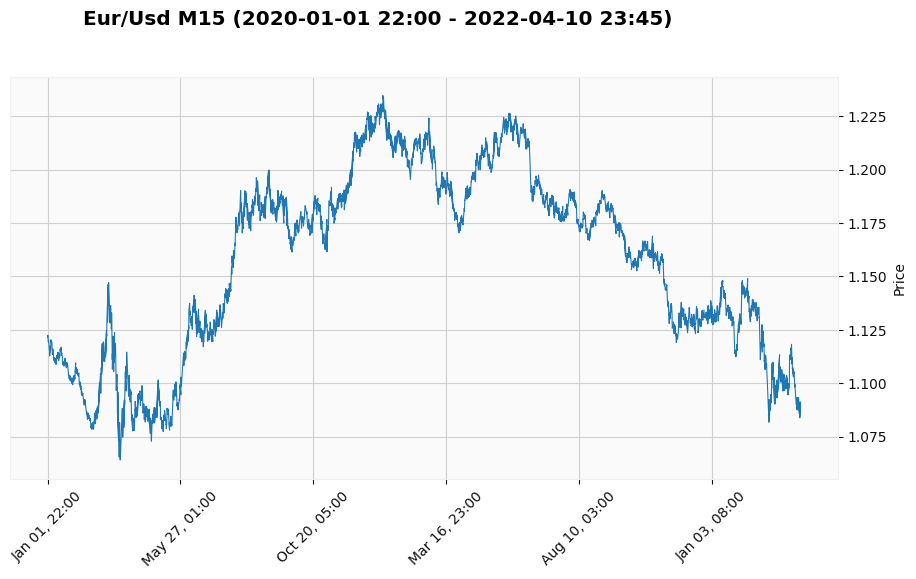

In [ ]:
title = 'Eur/Usd M15 (' + str(candles.iloc[0].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles, 
    type='line', 
    # volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

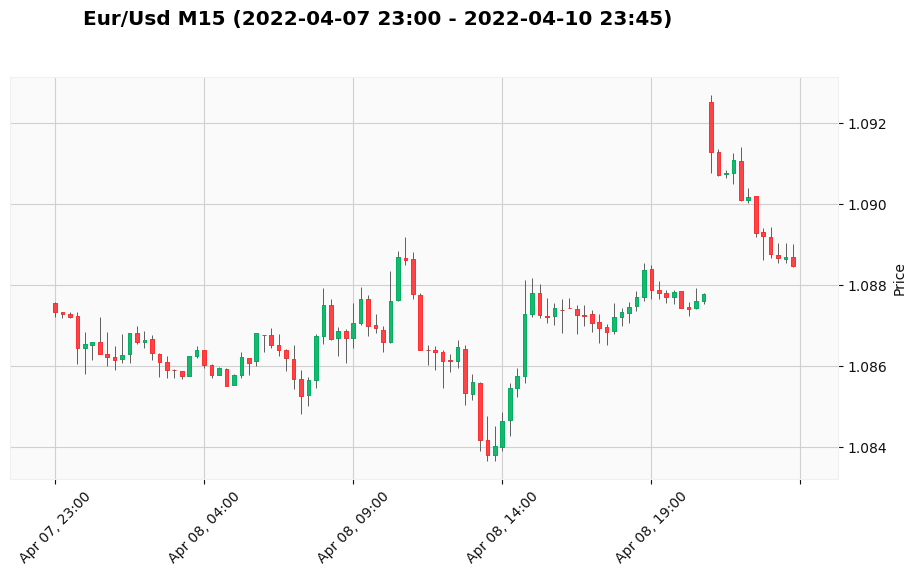

In [ ]:
title = 'Eur/Usd M15 (' + str(candles.iloc[-100].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-100:], 
    type='candle', 
    # volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

# Analisi Tecnica

## Medie Mobili

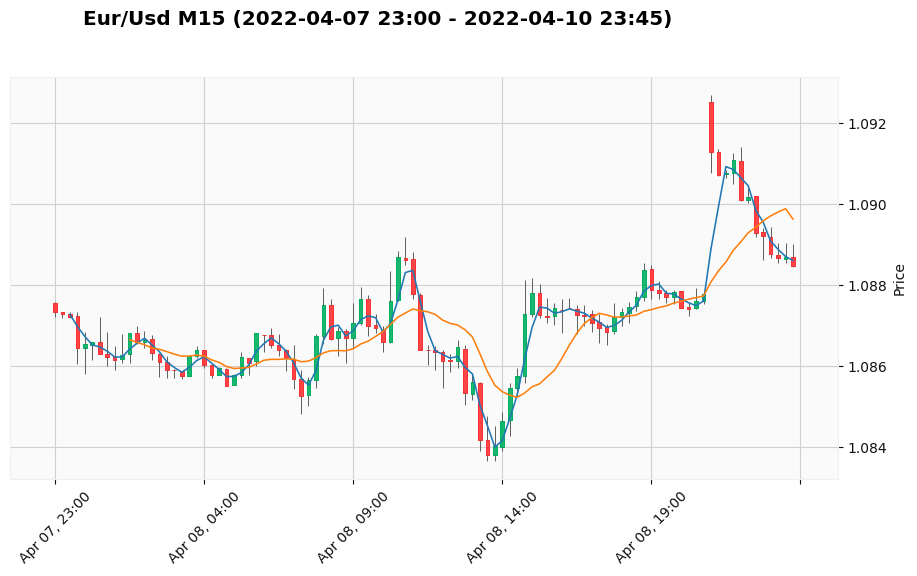

In [ ]:
mpf.plot(
    candles.iloc[-100:], 
    mav=(3, 11), 
    type='candle', 
    # volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

## Le bande di Bollinger

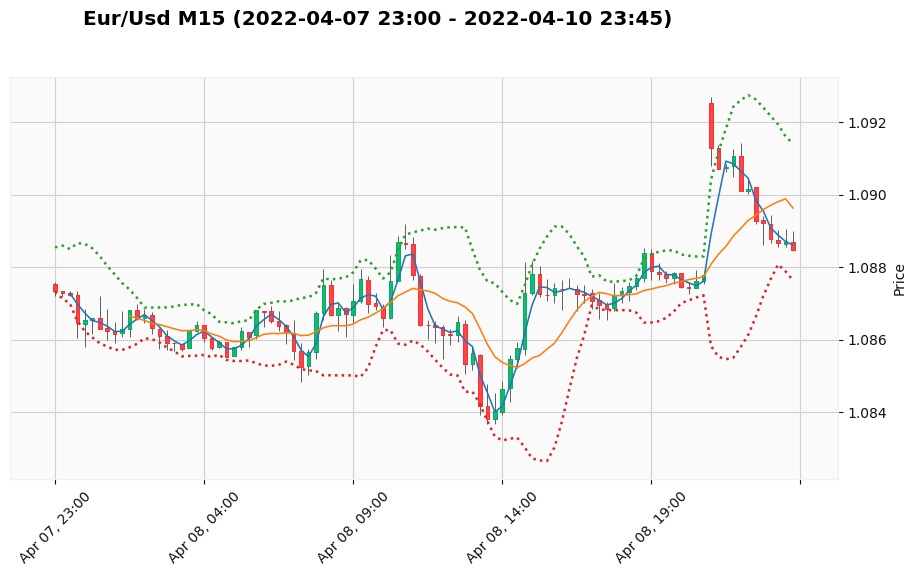

In [ ]:
mean = candles['close']
mean = mean.rolling(window=10).mean()
std_dev = candles['close']
std_dev = std_dev.rolling(window=10).std()
candles['UpperBB'] = mean + (2 * std_dev)
candles['LowerBB'] = mean - (2 * std_dev)
bollinger_bands = candles[['UpperBB', 'LowerBB']]

bollinger_bands_plot = mpf.make_addplot(bollinger_bands[-100:], linestyle='dotted')
mpf.plot(
    candles.iloc[-100:], 
    type='candle',
    mav=(3, 11),
    # volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    addplot=bollinger_bands_plot, 
    title=title
)

## Nuvole Ichimoku

1. Tenkan-Sen, è una media mobile risultante dal prezzo di massimo e minimo del 
titolo, su gli ultimi 9 periodi. Graficamente segue molto da vicino l’andamento dei prezzi ed è considerata la media più importante dell’indicatore;

2. Kijun-sen, è una media mobile semplice, anch’essa calcolata come la Tenkan-sen ma su un intervallo di tempo composto dagli ultimi 26 periodi. Il suo movimento è meno altalenante rispetto alla linea Tenkan-sen dovuto appunto dal periodo di calcolo più lungo;

3. Senkou span A, si tratta di una media mobile traslata di 26 periodi in avanti e calcolata come una media aritmetica dei valori della Tenkan-sen e della Kijun-sen. Permette agli analisti di ricevere una proiezione nel futuro dei valori medi. La linea Senkou span A delimita graficamente la nuvola;
4. Senkou span B, anch’essa è una media mobile semplice analoga alla Senkpu span A e calcolata come una media aritmetica dei valori corrispondenti delle medie Tenkan-sen e Kijun-sen. La differenza con la Senkou span A sta nel fatto che la B è calcolata su 52 periodi e non 26. Anch’essa delimita graficamente la nuvola dell’indicatore;

5. Chikou span, è l’ultima di queste 5 medie ed è calcolata su 26 periodi passati. Costituisce un elemento di supporto e produce segnali interessanti quanto interseca le medie Tenkan-sen e Kijiun-sen.

L’area tra la Senkou A e la Senkou B è la cosiddetta nuvola e quando la Senkou Span A è sopra la Senkou Span B abbiamo una nuvola rialzista e, naturalmente, viceversa.

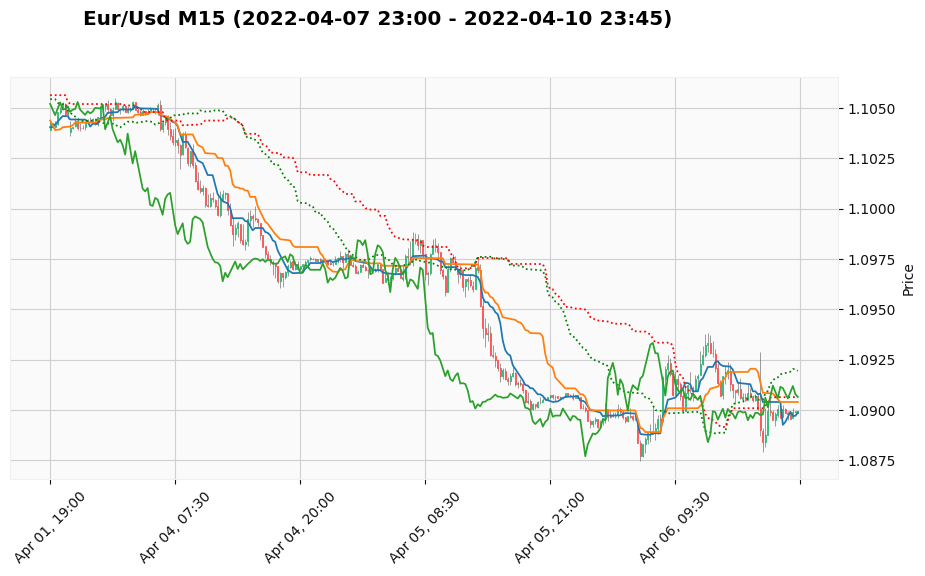

In [ ]:
period9_high = candles['high'].rolling(window=9).max()
period9_low = candles['low'].rolling(window=9).min()
candles['tenkan_sen'] = (period9_high + period9_low) / 2

# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = candles['high'].rolling(window=26).max()
period26_low = candles['low'].rolling(window=26).min()
candles['kijun_sen'] = (period26_high + period26_low) / 2

# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
candles['senkou_span_a'] = ((candles['tenkan_sen'] + candles['kijun_sen']) / 2).shift(26)

# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = candles['high'].rolling(window=52).max()
period52_low = candles['low'].rolling(window=52).min()
candles['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)

# The most current closing price plotted 22 time periods behind (optional)
chikou_span = candles['close'].shift(-22) # 22 according to investopedia

ichimoku = candles[['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b']]

# ichimoku_plot = mpf.make_addplot(ichimoku[-100:], panel=1)
candles_plot = mpf.make_addplot(candles['close'][-100:], panel=1, type='line', ylabel='Price', color='black')
#tenkan_sen = mpf.make_addplot(ichimoku['tenkan_sen'][-100:], panel=1, color='blue', ylabel='tenkan_sen')
add_plots= [
#            bollinger_bands_plot,
#            candles_plot,
            mpf.make_addplot(ichimoku['tenkan_sen'][-500:-200]),
            mpf.make_addplot(ichimoku['kijun_sen'][-500:-200]),
            mpf.make_addplot(ichimoku['senkou_span_a'][-500:-200], linestyle='dotted', color='green'),
            mpf.make_addplot(ichimoku['senkou_span_b'][-500:-200], linestyle='dotted', color='red'),
            mpf.make_addplot(chikou_span[-500:-200])
           ]

mpf.plot(
    candles.iloc[-500:-200], 
    type='candle',
    # mav=(3, 11),
    # volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    addplot=add_plots, 
    title=title
)

## Canali di Donchian

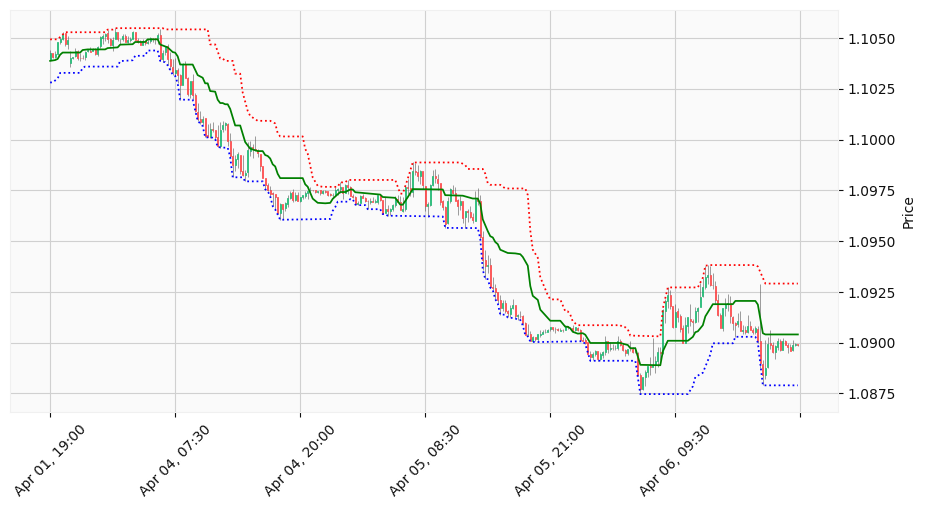

In [ ]:
#Calcolo canali Donchian. Questa tecnica ha 3 linee, ma proviamo ad inserire nel dataset solo la centrale
don_line_sup = candles['high'].rolling(window=20).max()
don_line_inf = candles['low'].rolling(window=20).min()
don_line_cen = (don_line_sup + don_line_inf) / 2 #semplice media tra il minimo e il massimo in un dato tempo (20 qui)

#metto tutto nel dataset
candles['don_high'] = don_line_sup
candles['don_low'] = don_line_inf
candles['don_mean'] = don_line_cen

don_sup_plot = mpf.make_addplot(don_line_sup[-500:-200], linestyle='dotted', color='red')
don_inf_plot = mpf.make_addplot(don_line_inf[-500:-200], linestyle='dotted', color='blue')
don_cen_plot = mpf.make_addplot(don_line_cen[-500:-200], color='green')

mpf.plot(
    candles.iloc[-500:-200],
    type='candle',
    figratio=(24,12),
    style='yahoo',
    addplot=[don_sup_plot, don_inf_plot, don_cen_plot]
)

## Prezzo su volume

In [ ]:
'''
price_over_volume = (candles['close'] - candles['open']) / candles['volume']

candles['price_over_vol'] = price_over_volume

price_over_volume_plot = mpf.make_addplot(price_over_volume[-500:-400], panel=1, color='blue')
mpf.plot(
    candles.iloc[-500:-400],  
    type='candle', 
    # volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[bollinger_bands_plot, price_over_volume_plot],
    title=title
)
'''

"\nprice_over_volume = (candles['close'] - candles['open']) / candles['volume']\n\ncandles['price_over_vol'] = price_over_volume\n\nprice_over_volume_plot = mpf.make_addplot(price_over_volume[-500:-400], panel=1, color='blue')\nmpf.plot(\n    candles.iloc[-500:-400],  \n    type='candle', \n    # volume=True, \n    mav=(3, 11),\n    figratio=(24,12), \n    style='yahoo', \n    addplot=[bollinger_bands_plot, price_over_volume_plot],\n    title=title\n)\n"

## Accelerazione volumetrica

In [ ]:
'''
volume_diff = candles['volume'] - candles['volume'].shift(1)
volume_diff_plot = mpf.make_addplot(volume_diff[-100:], panel=2, type='bar', ylabel='Vol.Acc.')
candles['vol_diff'] = volume_diff

mpf.plot(
    candles.iloc[-100:],  
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[
        bollinger_bands_plot, 
        price_over_volume_plot, 
        volume_diff_plot
    ], 
    title=title
)
'''

"\nvolume_diff = candles['volume'] - candles['volume'].shift(1)\nvolume_diff_plot = mpf.make_addplot(volume_diff[-100:], panel=2, type='bar', ylabel='Vol.Acc.')\ncandles['vol_diff'] = volume_diff\n\nmpf.plot(\n    candles.iloc[-100:],  \n    type='candle', \n    volume=True, \n    mav=(3, 11),\n    figratio=(24,12), \n    style='yahoo', \n    addplot=[\n        bollinger_bands_plot, \n        price_over_volume_plot, \n        volume_diff_plot\n    ], \n    title=title\n)\n"

# Creazione dataset temporale

## Normalizzazione dei dati

In [ ]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles_norm = scaler.fit_transform(candles)
candles_norm = np.asarray(candles, dtype=np.float32)

print(candles.iloc[0])
print('  ------')
print(candles_norm[0])

open             1.12160
close            1.12152
high             1.12185
low              1.12124
UpperBB              NaN
LowerBB              NaN
tenkan_sen           NaN
kijun_sen            NaN
senkou_span_a        NaN
senkou_span_b        NaN
don_high             NaN
don_low              NaN
don_mean             NaN
Name: 2020-01-01 22:00:00+00:00, dtype: float64
  ------
[1.1216  1.12152 1.12185 1.12124     nan     nan     nan     nan     nan
     nan     nan     nan     nan]


## Rimozione valori NaN
derivati dal calcolo delle bande di Bollinger e nuvole Ichimoku

In [ ]:
candles.head(78)

,open,close,high,low,UpperBB,LowerBB,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,don_high,don_low,don_mean
date,,,,,,,,,,,,,
2020-01-01 22:00:00+00:00,1.12160,1.12152,1.12185,1.12124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:15:00+00:00,1.12150,1.12163,1.12169,1.12143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:30:00+00:00,1.12166,1.12162,1.12169,1.12157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:45:00+00:00,1.12166,1.12157,1.12173,1.12156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 23:00:00+00:00,1.12158,1.12203,1.12228,1.12156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 16:15:00+00:00,1.11876,1.11846,1.11876,1.11831,1.119880,1.116406,1.11867,1.11871,1.120875,NaN,1.12032,1.11702,1.11867
2020-01-02 16:30:00+00:00,1.11846,1.11759,1.11867,1.11755,1.119768,1.116308,1.11867,1.11867,1.120773,NaN,1.12032,1.11702,1.11867
2020-01-02 16:45:00+00:00,1.11758,1.11664,1.11776,1.11654,1.119869,1.115985,1.11843,1.11843,1.120362,NaN,1.12032,1.11654,1.11843


In [ ]:
candles.tail(23)

,open,close,high,low,UpperBB,LowerBB,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,don_high,don_low,don_mean
date,,,,,,,,,,,,,
2022-04-08 18:15:00+00:00,1.08732,1.08747,1.08759,1.08708,1.087634,1.086810,1.087110,1.085920,1.087282,1.087010,1.08818,1.08366,1.085920
2022-04-08 18:30:00+00:00,1.08748,1.08771,1.08785,1.08737,1.087762,1.086746,1.087190,1.085920,1.087170,1.087010,1.08818,1.08366,1.085920
2022-04-08 18:45:00+00:00,1.08770,1.08838,1.08854,1.08760,1.088225,1.086473,1.087535,1.086100,1.087170,1.087010,1.08854,1.08392,1.086230
2022-04-08 19:00:00+00:00,1.08840,1.08789,1.08850,1.08766,1.088348,1.086476,1.087535,1.086100,1.087170,1.087010,1.08854,1.08429,1.086415
2022-04-08 19:15:00+00:00,1.08788,1.08782,1.08811,1.08766,1.088431,1.086509,1.087535,1.086100,1.087065,1.087010,1.08854,1.08523,1.086885
2022-04-08 19:30:00+00:00,1.08782,1.08770,1.08789,1.08756,1.088460,1.086604,1.087535,1.086100,1.086972,1.087010,1.08854,1.08558,1.087060
2022-04-08 19:45:00+00:00,1.08771,1.08783,1.08787,1.08754,1.088466,1.086774,1.087670,1.086100,1.086210,1.086555,1.08854,1.08653,1.087535
2022-04-08 20:00:00+00:00,1.08785,1.08745,1.08785,1.08744,1.088350,1.087010,1.087770,1.086100,1.085792,1.086430,1.08854,1.08653,1.087535
2022-04-08 20:15:00+00:00,1.08746,1.08742,1.08758,1.08725,1.088317,1.087085,1.087810,1.086230,1.085792,1.086430,1.08854,1.08653,1.087535


In [ ]:
candles_norm = candles_norm[78:]

In [ ]:
print(candles_norm[0])
print(candles_norm[-1])

[1.11707   1.11707   1.1172    1.11679   1.1199505 1.1156075 1.11835
 1.11835   1.120355  1.12088   1.12032   1.11638   1.11835  ]
[1.08869   1.08847   1.08901   1.08846   1.0914075 1.0876385 1.08994
 1.08961   1.0867724 1.08643   1.09269   1.08725   1.08997  ]


## Costruzione dataset basato su serie temporali

![dataset temporale](images/dataset_temporale.png)

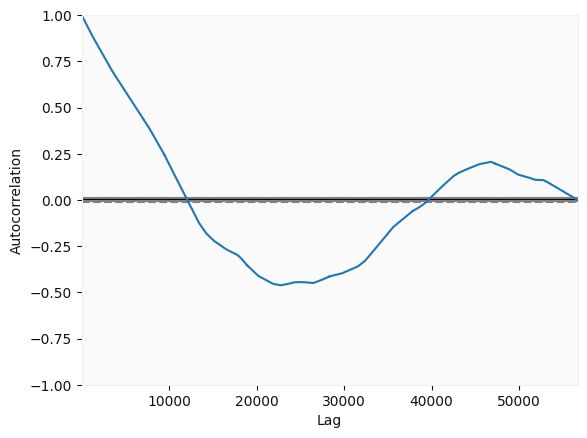

In [ ]:
import pandas as pd
pd.plotting.autocorrelation_plot(candles['close'])

In [ ]:
candles.head()

,open,close,high,low,UpperBB,LowerBB,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,don_high,don_low,don_mean
date,,,,,,,,,,,,,
2020-01-01 22:00:00+00:00,1.12160,1.12152,1.12185,1.12124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:15:00+00:00,1.12150,1.12163,1.12169,1.12143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:30:00+00:00,1.12166,1.12162,1.12169,1.12157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:45:00+00:00,1.12166,1.12157,1.12173,1.12156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 23:00:00+00:00,1.12158,1.12203,1.12228,1.12156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x_candles = []
x_time = []
y_close = []
y_high = []
y_low = []

# 96 candele M15 compongono una giornata
step_back = 96 

for i in range(len(candles_norm) - step_back - 4):
    x_candles.append(candles_norm[i:i + step_back])
    
    # 78 per la rimozione dei valori NaN derivati dal calcolo delle Bollinger Bands e nuvole Ichimoku
    t = candles.iloc[78 + i + step_back -1].name 
    
    x_time.append([t.minute / 60 , t.hour / 24, t.weekday() / 7])

    y_close.append(candles_norm[i+step_back:i+step_back+4, 1])
    y_high.append(candles_norm[i+step_back:i+step_back+4, 1])
    y_low.append(candles_norm[i+step_back:i+step_back+4, 1])


print(len(y_close))

56514


In [ ]:
print(x_candles[0])
print(x_time[0])

print(y_close[0])
print(y_high[0])
print(y_low[0])

[[1.11707  1.11707  1.1172   ... 1.12032  1.11638  1.11835 ]
 [1.11706  1.117    1.11719  ... 1.12032  1.11638  1.11835 ]
 [1.11701  1.1165   1.11714  ... 1.12032  1.11638  1.11835 ]
 ...
 [1.11739  1.11722  1.11754  ... 1.118    1.11284  1.11542 ]
 [1.11722  1.11729  1.11743  ... 1.118    1.11289  1.115445]
 [1.1173   1.11729  1.11739  ... 1.118    1.113    1.1155  ]]
[0.25, 0.7083333333333334, 0.5714285714285714]
[1.11714 1.11724 1.11727 1.11703]
[1.11714 1.11724 1.11727 1.11703]
[1.11714 1.11724 1.11727 1.11703]


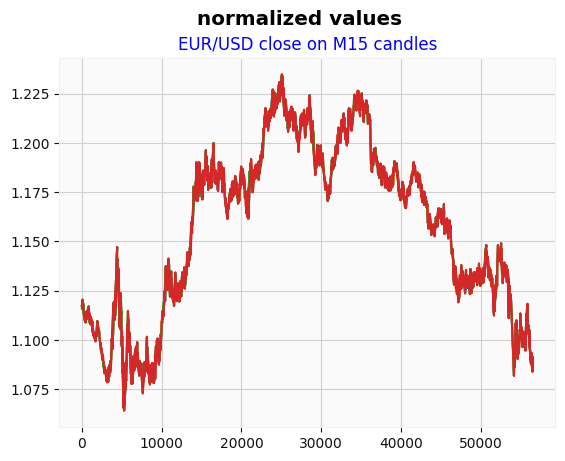

In [ ]:
plt.plot(y_close)
plt.title('EUR/USD close on M15 candles', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('normalized values')
plt.show()

### Creazione dataset per addestramento e validazione del modello predittivo

In [ ]:
split_point_train = int(len(x_candles) * 0.8)
split_point_validation = int(len(x_candles) * 0.1)

x_train_candles = np.asarray(x_candles[:split_point_train], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point_train], dtype=np.float32)

y_train_close = np.asarray(y_close[:split_point_train], dtype=np.float32)
y_train_high = np.asarray(y_high[:split_point_train], dtype=np.float32)
y_train_low = np.asarray(y_low[:split_point_train], dtype=np.float32)

x_validation_candles = np.asarray(x_candles[split_point_train:split_point_train+split_point_validation], dtype=np.float32)
x_validation_time = np.asarray(x_time[split_point_train:split_point_train+split_point_validation], dtype=np.float32)

y_validation_close = np.asarray(y_close[split_point_train:split_point_train+split_point_validation], dtype=np.float32)
y_validation_high = np.asarray(y_high[split_point_train:split_point_train+split_point_validation], dtype=np.float32)
y_validation_low = np.asarray(y_low[split_point_train:split_point_train+split_point_validation], dtype=np.float32)

x_test_candles = np.asarray(x_candles[split_point_train+split_point_validation:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point_train+split_point_validation:], dtype=np.float32)

y_test_close = np.asarray(y_close[split_point_train+split_point_validation:], dtype=np.float32)
y_test_high = np.asarray(y_high[split_point_train+split_point_validation:], dtype=np.float32)
y_test_low = np.asarray(y_low[split_point_train+split_point_validation:], dtype=np.float32)

In [ ]:
print(x_train_candles.shape)
print(x_train_time.shape)
print('\n')
print(y_train_close.shape)
print(y_train_high.shape)
print(y_train_low.shape)
print('----------------------------')
print(x_validation_candles.shape)
print(x_validation_time.shape)
print('\n')
print(y_validation_close.shape)
print(y_validation_high.shape)
print(y_validation_low.shape)
print('----------------------------')
print(x_test_candles.shape)
print(x_test_time.shape)
print('\n')
print(y_test_close.shape)
print(y_test_high.shape)
print(y_test_low.shape)

(45211, 96, 13)
(45211, 3)


(45211, 4)
(45211, 4)
(45211, 4)
----------------------------
(5651, 96, 13)
(5651, 3)


(5651, 4)
(5651, 4)
(5651, 4)
----------------------------
(5652, 96, 13)
(5652, 3)


(5652, 4)
(5652, 4)
(5652, 4)


## Implementazione modello predittivo

#### architettura della rete neurale artificiale convolutiva composta con celle LSTM

![TheNet](images/the_net.png)

#### funzione di attivazione "Swish"

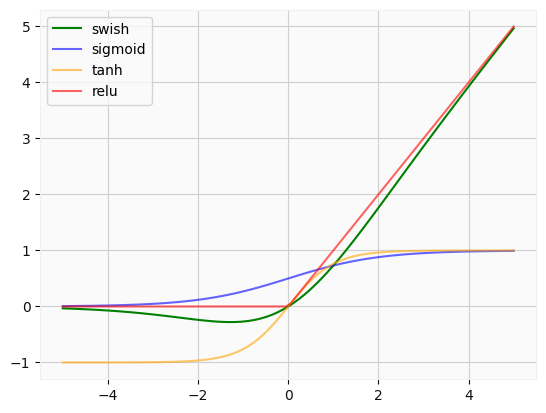

In [ ]:
def swish(x):
    return keras.backend.sigmoid(x) * x

x = np.linspace(-5, 5, 100)
plt.plot(x, keras.backend.eval(swish(x)), label='swish', color='green')
plt.plot(x, keras.backend.eval(keras.backend.sigmoid(x)), label='sigmoid', color='blue', alpha=0.6)
plt.plot(x, keras.backend.eval(keras.backend.tanh(x)), label='tanh', color='orange', alpha=0.6)
plt.plot(x, keras.backend.eval(keras.backend.relu(x)), label='relu', color='red', alpha=0.6)
plt.legend(loc="upper left")
plt.show()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 96, 13)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 96, 24)       6888        ['Candles[0][0]']                
                                                                                                  
 conv1d_38 (Conv1D)             (None, 96, 24)       6888        ['Candles[0][0]']                
                                                                                                  
 conv1d_46 (Conv1D)             (None, 96, 24)       6888        ['Candles[0][0]']                
                                                                                            

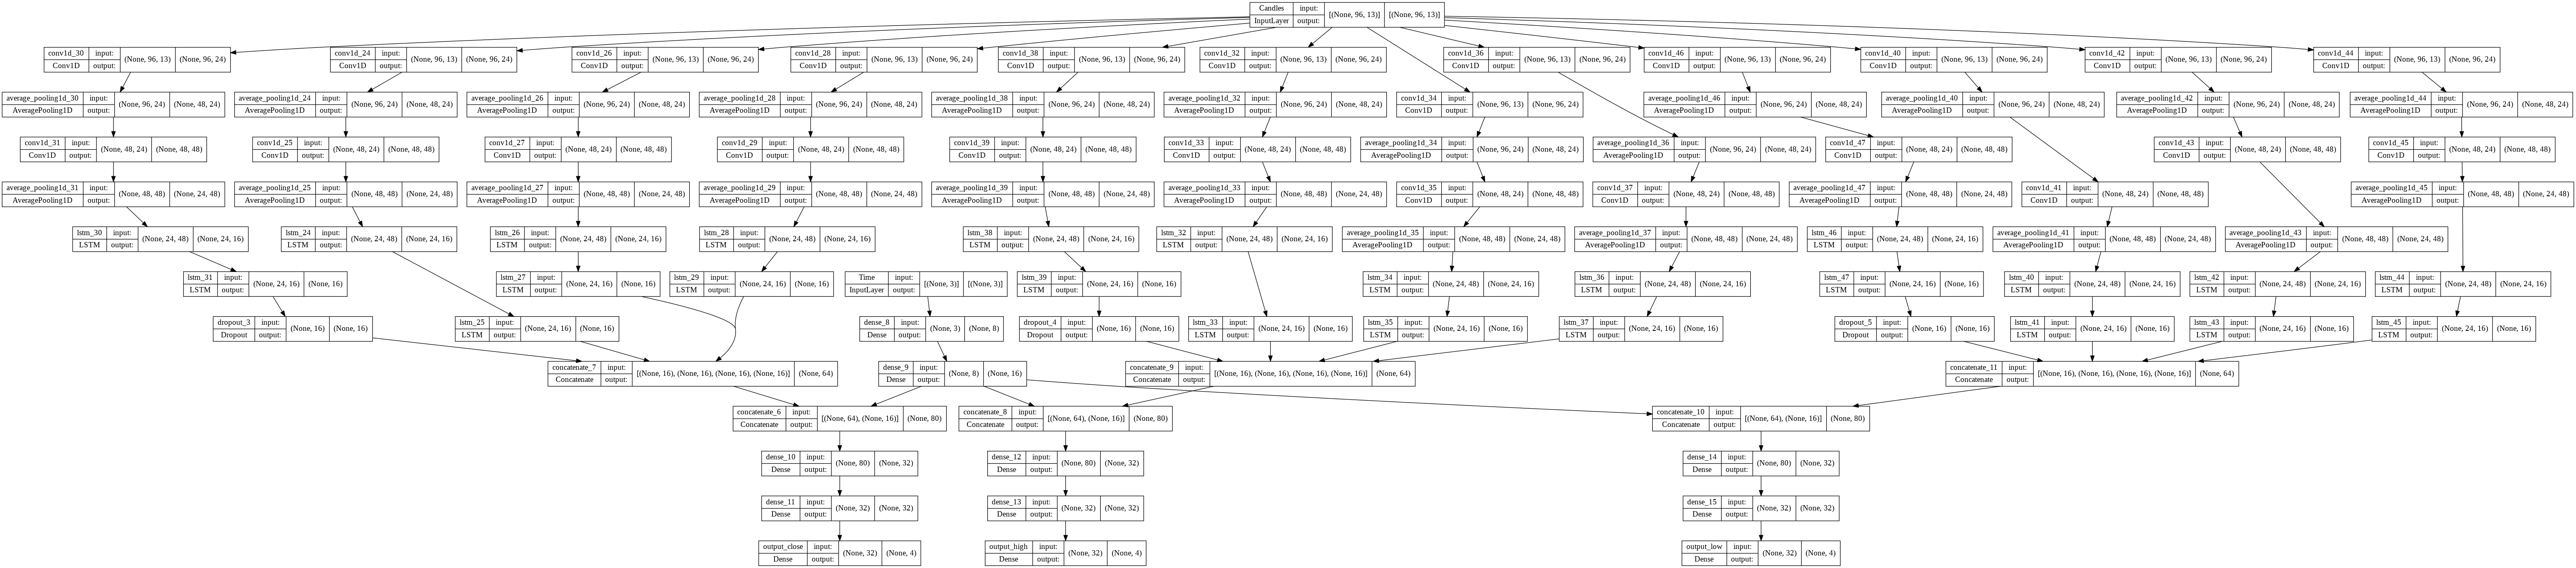

In [ ]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=24,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=48,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=16, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=16)(lstm_1)
    
    return lstm_2

def layers_conv(input_candles):
  conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=2)
  conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=5, kernel_size_2=3)
  conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=11, kernel_size_2=7)
  conv_4 = get_conv_lstm_block(input_candles, kernel_size_1=22, kernel_size_2=12)

  conv_4 = keras.layers.Dropout(0.3)(conv_4)

  return keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, conv_4])


input_candles = keras.Input(shape=(x_train_candles.shape[1:]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1]), name='Time')

dense_time_1 = keras.layers.Dense(units=8, activation='swish')(input_time)
dense_time_2 = keras.layers.Dense(units=16, activation='swish')(dense_time_1)

conc1 = keras.layers.Concatenate(axis=-1)([layers_conv(input_candles), dense_time_2])
conc2 = keras.layers.Concatenate(axis=-1)([layers_conv(input_candles), dense_time_2])
conc3 = keras.layers.Concatenate(axis=-1)([layers_conv(input_candles), dense_time_2])

# prima uscita
dense_1 = keras.layers.Dense(units=32, activation=keras.activations.swish)(conc1)
dense_2 = keras.layers.Dense(units=32, activation=keras.activations.swish)(dense_1)

output1 = keras.layers.Dense(units=4, activation=keras.activations.linear, name='output_close')(dense_2)

# seconda uscita
dense_1 = keras.layers.Dense(units=32, activation=keras.activations.swish)(conc2)
dense_2 = keras.layers.Dense(units=32, activation=keras.activations.swish)(dense_1)

output2 = keras.layers.Dense(units=4, activation=keras.activations.linear, name='output_high')(dense_2)

# terza uscita
dense_1 = keras.layers.Dense(units=32, activation=keras.activations.swish)(conc3)
dense_2 = keras.layers.Dense(units=32, activation=keras.activations.swish)(dense_1)

output3 = keras.layers.Dense(units=4, activation=keras.activations.linear, name='output_low')(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=[output1, output2, output3])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.mean_absolute_error)

model.summary()

keras.utils.plot_model(model, path + "trading_net.png", show_shapes=True)

In [ ]:
# inserire Model check point callback
history = model.fit(
    [x_train_candles, x_train_time],
    [y_train_close, y_train_high, y_train_low],
    epochs=30,
    batch_size=512,
    validation_data=(
        [x_validation_candles, x_validation_time],
        [y_validation_close, 
         y_validation_high, 
         y_validation_low]
    )
)

Epoch 1/30
89/89 [==============================] - 24s 264ms/step - loss: 0.1012 - output_close_loss: 0.0329 - output_high_loss: 0.0329 - output_low_loss: 0.0353 - val_loss: 0.0644 - val_output_close_loss: 0.0190 - val_output_high_loss: 0.0192 - val_output_low_loss: 0.0262
Epoch 2/30
89/89 [==============================] - 22s 252ms/step - loss: 0.0783 - output_close_loss: 0.0222 - output_high_loss: 0.0268 - output_low_loss: 0.0294 - val_loss: 0.0923 - val_output_close_loss: 0.0151 - val_output_high_loss: 0.0481 - val_output_low_loss: 0.0291
Epoch 3/30
89/89 [==============================] - 22s 252ms/step - loss: 0.0578 - output_close_loss: 0.0192 - output_high_loss: 0.0170 - output_low_loss: 0.0216 - val_loss: 0.0784 - val_output_close_loss: 0.0223 - val_output_high_loss: 0.0134 - val_output_low_loss: 0.0427
Epoch 4/30
89/89 [==============================] - 23s 253ms/step - loss: 0.0456 - output_close_loss: 0.0132 - output_high_loss: 0.0174 - output_low_loss: 0.0149 - val_loss: 

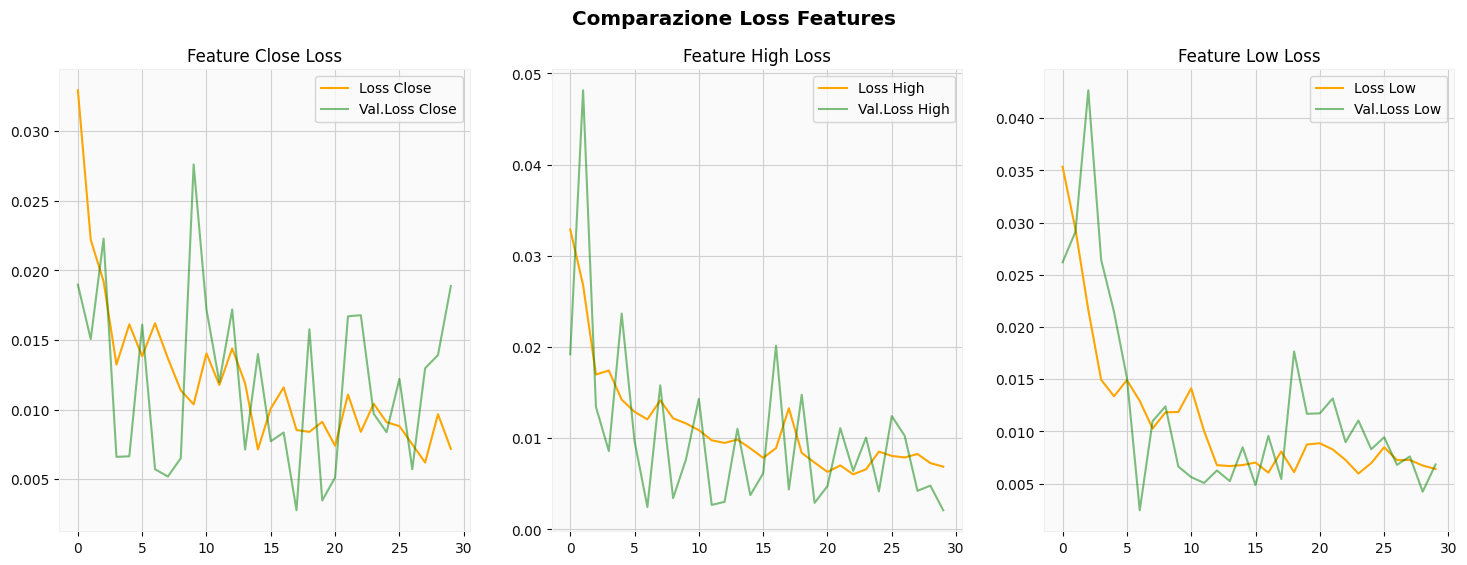

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Comparazione Loss Features')

ax1.set_title('Feature Close Loss')
ax1.plot(history.history['output_close_loss'], label='Loss Close', color='orange')
ax1.plot(history.history['val_output_close_loss'], label='Val.Loss Close', color='green', alpha=0.5)
ax1.legend()

ax2.set_title('Feature High Loss')
ax2.plot(history.history['output_high_loss'], label='Loss High', color='orange')
ax2.plot(history.history['val_output_high_loss'], label='Val.Loss High', color='green', alpha=0.5)
ax2.legend()

ax3.set_title('Feature Low Loss')
ax3.plot(history.history['output_low_loss'], label='Loss Low', color='orange')
ax3.plot(history.history['val_output_low_loss'], label='Val.Loss Low', color='green', alpha=0.5)
ax3.legend()

plt.show()

In [ ]:
model.save_weights(path + 'weights_30_epochs.h5')
model.save(path + 'model_weights_30_epochs.h5')

### Utilizzo e validazione del modello predittivo

In [ ]:
preds = model.predict([x_test_candles, x_test_time], batch_size=256)
preds_close = preds[0]
preds_high = preds[1]
preds_low = preds[2]

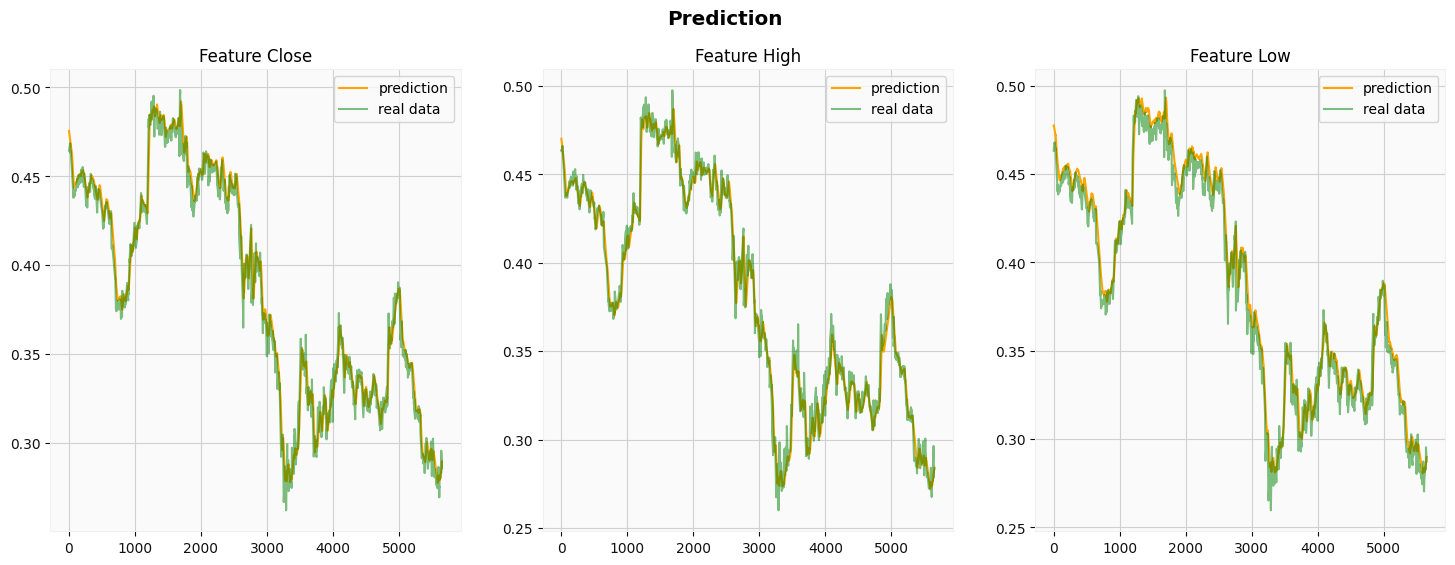

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Prediction')

ax1.set_title('Feature Close')
ax1.plot(preds_close, label='prediction', color='orange')
ax1.plot(y_test_close, label='real data', color='green', alpha=0.5)
ax1.legend()

ax2.set_title('Feature High')
ax2.plot(preds_high, label='prediction', color='orange')
ax2.plot(y_test_high, label='real data', color='green', alpha=0.5)
ax2.legend()

ax3.set_title('Feature Low')
ax3.plot(preds_low, label='prediction', color='orange')
ax3.plot(y_test_low, label='real data', color='green', alpha=0.5)
ax3.legend()

plt.show()

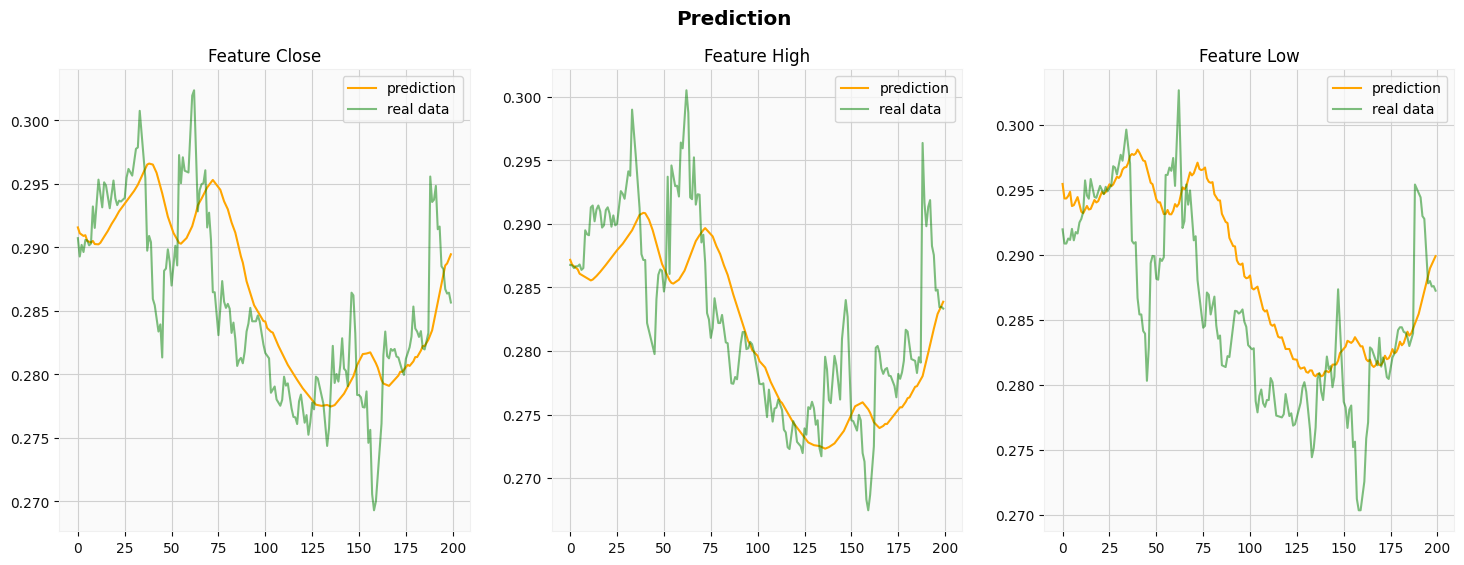

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Prediction')

ax1.set_title('Feature Close')
ax1.plot(preds_close[-200:], label='prediction', color='orange')
ax1.plot(y_test_close[-200:], label='real data', color='green', alpha=0.5)
ax1.legend()

ax2.set_title('Feature High')
ax2.plot(preds_high[-200:], label='prediction', color='orange')
ax2.plot(y_test_high[-200:], label='real data', color='green', alpha=0.5)
ax2.legend()

ax3.set_title('Feature Low')
ax3.plot(preds_low[-200:], label='prediction', color='orange')
ax3.plot(y_test_low[-200:], label='real data', color='green', alpha=0.5)
ax3.legend()

plt.show()

In [ ]:
x_candles[0][1]

array([0.38624934, 0.38601161, 0.38310125, 0.38575362, 0.38749866,
       0.38682526, 0.38667341, 0.38347451, 0.39158628, 0.39156239,
       0.38146413, 0.38774251, 0.38353473])

In [ ]:
def denorm(value):
    example = [0.5 for x in range(13)]
    example[1] = value
    return scaler.inverse_transform([example])[0][1]

In [ ]:
pips_total = 0
total_pips_history = []
single_pips_history = []

for i in range(split_point_train+split_point_validation, len(x_candles)):
    prediction = preds_close[i - (split_point_train+split_point_validation)][0]
    predicted_close = denorm(prediction)
    previous_close = denorm(candles_norm[i-1][1])
    actual_close = denorm(candles_norm[i][1])
    real_next_close = denorm(candles_norm[i+1][1])

    if previous_close < predicted_close:  # buy
        profit = real_next_close - actual_close
        pips_total += profit
        total_pips_history.append(pips_total)
        single_pips_history.append(profit)
        
    if previous_close > predicted_close:  # sell
        profit = actual_close - real_next_close
        pips_total += profit
        total_pips_history.append(pips_total)
        single_pips_history.append(profit)

Total earned 0.3075300000000021


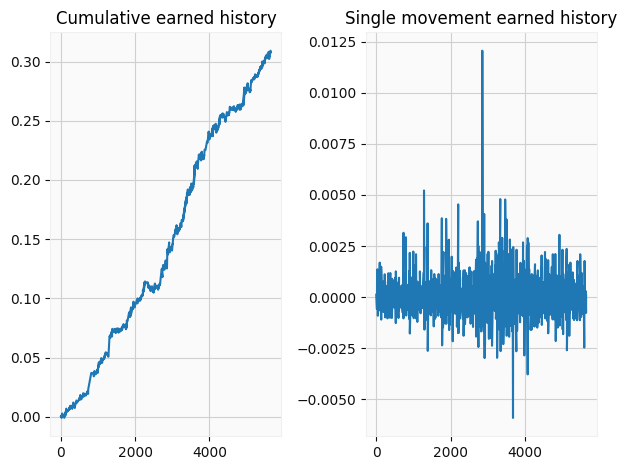

In [ ]:
print('Total earned', pips_total)

plt.subplot(1, 2, 1)
plt.plot(total_pips_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_pips_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## addestramento su più epoche

In [ ]:
preds_close_old = preds_close
preds_high_old = preds_high
preds_low_old = preds_low

y_test_close_old = y_test_close
y_test_high_old = y_test_high
y_test_low_old = y_test_low

In [ ]:
history = model.fit(
    [x_train_candles, x_train_time],
    [y_train_close, y_train_high, y_train_low],
    epochs=200,
    batch_size=512,
    initial_epoch=31,
    validation_data=(
        [x_validation_candles, x_validation_time],
        [y_validation_close, y_validation_high, y_validation_low]
    )
)

In [ ]:
model.save_weights(path + 'weights.h5')
model.save(path + 'model_weights.h5')

In [ ]:
#model.compile(optimizer=keras.optimizers.SGD(), 
#              loss=keras.losses.mean_absolute_error)

# model = model.load_weights(path + 'wheights.h5')
model = keras.models.load_model(path + 'model_weights_b512.h5')

In [ ]:
history = model.fit(
    [x_train_candles, x_train_time],
    [y_train_close, y_train_high, y_train_low],
    epochs=200,
    batch_size=512,
    initial_epoch=501,
    validation_data=(
        [x_validation_candles, x_validation_time],
        [y_validation_close, y_validation_high, y_validation_low]
    )
)

In [ ]:
model.save_weights(path + 'sgd_weights.h5')
model.save(path + 'model_sgd_weights.h5')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Comparazione Loss Features')

ax1.set_title('Feature Close Loss')
ax1.plot(history.history['output_close_loss'], label='Loss Close', color='orange')
ax1.plot(history.history['val_output_close_loss'], label='Val.Loss Close', color='green', alpha=0.5)
ax1.legend()

ax2.set_title('Feature High Loss')
ax2.plot(history.history['output_high_loss'], label='Loss High', color='orange')
ax2.plot(history.history['val_output_high_loss'], label='Val.Loss High', color='green', alpha=0.5)
ax2.legend()

ax3.set_title('Feature Low Loss')
ax3.plot(history.history['output_low_loss'], label='Loss Low', color='orange')
ax3.plot(history.history['val_output_low_loss'], label='Val.Loss Low', color='green', alpha=0.5)
ax3.legend()

plt.show()

In [ ]:
preds = model.predict([x_test_candles, x_test_time], batch_size=256)
preds_close = preds[0]
preds_high = preds[1]
preds_low = preds[2]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(18, 12)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('Features Close 1500 epochs')
ax1.plot(preds_close[-500:], color='orange', label='predictions')
ax1.plot(y_test_close[-500:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('Features High 1500 epochs')
ax2.plot(preds_high[-500:], color='orange', label='predictions')
ax2.plot(y_test_high[-500:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('Features Close 1500 epochs')
ax3.plot(preds_low[-500:], color='orange', label='predictions')
ax3.plot(y_test_low[-500:], color='green', alpha=0.5, label='real data')
ax3.legend()

plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(18, 10)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('Features Close 500 epochs')
ax1.plot(preds_close[-100:], color='orange', label='predictions')
ax1.plot(y_test_close[-100:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('Features High 500 epochs')
ax2.plot(preds_high[-100:], color='orange', label='predictions')
ax2.plot(y_test_high[-100:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('Features Low 500 epochs')
ax3.plot(preds_low[-100:], color='orange', label='predictions')
ax3.plot(y_test_low[-100:], color='green', alpha=0.5, label='real data')
ax3.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(18, 12)
fig.suptitle('Comparison of short and medium trainings')

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]
ax5 = ax[2,0]
ax6 = ax[2,1]

ax1.set_title('Features Close 30 epochs')
ax1.plot(preds_close_old, color='orange', label='predictions')
ax1.plot(y_test_close_old, color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('Features Close 1500 epochs')
ax2.plot(preds_close, color='orange', label='predictions')
ax2.plot(y_test_close, color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('Features High 30 epochs')
ax3.plot(preds_high_old, color='orange', label='predictions')
ax3.plot(y_test_high_old, color='green', alpha=0.5, label='real data')
ax3.legend()

ax4.set_title('Features High 1500 epochs')
ax4.plot(preds_high, color='orange', label='predictions')
ax4.plot(y_test_high, color='green', alpha=0.5, label='real data')
ax4.legend()

ax5.set_title('Features Low 30 epochs')
ax5.plot(preds_low_old, color='orange', label='predictions')
ax5.plot(y_test_low_old, color='green', alpha=0.5, label='real data')
ax5.legend()

ax6.set_title('Features Low 1500 epochs')
ax6.plot(preds_low, color='orange', label='predictions')
ax6.plot(y_test_low, color='green', alpha=0.5, label='real data')
ax6.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(18, 12)
fig.suptitle('Comparison of short and medium trainings')

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]
ax5 = ax[2,0]
ax6 = ax[2,1]

ax1.set_title('Features Close 30 epochs')
ax1.plot(preds_close_old[-200:], color='orange', label='predictions')
ax1.plot(y_test_close_old[-200:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('Features Close 1500 epochs')
ax2.plot(preds_close[-200:], color='orange', label='predictions')
ax2.plot(y_test_close[-200:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('Features High 30 epochs')
ax3.plot(preds_high_old[-200:], color='orange', label='predictions')
ax3.plot(y_test_high_old[-200:], color='green', alpha=0.5, label='real data')
ax3.legend()

ax4.set_title('Features High 1500 epochs')
ax4.plot(preds_high[-200:], color='orange', label='predictions')
ax4.plot(y_test_high[-200:], color='green', alpha=0.5, label='real data')
ax4.legend()

ax5.set_title('Features Low 30 epochs')
ax5.plot(preds_low_old[-200:], color='orange', label='predictions')
ax5.plot(y_test_low_old[-200:], color='green', alpha=0.5, label='real data')
ax5.legend()

ax6.set_title('Features Low 1500 epochs')
ax6.plot(preds_low[-200:], color='orange', label='predictions')
ax6.plot(y_test_low[-200:], color='green', alpha=0.5, label='real data')
ax6.legend()

plt.show()

In [ ]:
pips_total = 0
total_pips_history = []
single_pips_history = []

for i in range(split_point_train+split_point_validation, len(x_candles)):
    prediction = preds_close[i - (split_point_train+split_point_validation)][0]
    predicted_close = denorm(prediction)
    previous_close = denorm(candles_norm[i-1][1])
    actual_close = denorm(candles_norm[i][1])
    real_next_close = denorm(candles_norm[i+1][1])

    if previous_close < predicted_close:  # buy
        profit = real_next_close - actual_close
        pips_total += profit
        total_pips_history.append(pips_total)
        single_pips_history.append(profit)
        
    if previous_close > predicted_close:  # sell
        profit = actual_close - real_next_close
        pips_total += profit
        total_pips_history.append(pips_total)
        single_pips_history.append(profit)

In [ ]:
print('Total earned', pips_total)

plt.subplot(1, 2, 1)
plt.plot(total_pips_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_pips_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

### Previsioni futuro

In [ ]:
print(x_test_time.shape)
print(x_test_time[-1])
print(x_test_time[1])

In [ ]:
print(x_test_candles.shape)
print(x_test_candles[-1])

In [ ]:
preds_close = np.reshape(preds_close, -1)
preds_high = np.reshape(preds_high, -1)
preds_low = np.reshape(preds_low, -1)

df_preds = pd.DataFrame({'preds_close' : preds_close.tolist(), 
                         'preds_high' : preds_high.tolist(), 
                         'preds_low' : preds_low.tolist()})

df_preds['preds_open'] = df_preds['preds_close'].shift(1)
df_preds = df_preds[['preds_open', 'preds_close', 'preds_high', 'preds_low']]
df_preds['day'] = x_test_time[:, 2] * 7
df_preds['hour'] = x_test_time[:, 1] * 24
df_preds['minute'] = x_test_time[:, 0] * 60

df_preds.tail(30)

In [ ]:
print(len(df_preds))